# Convolution And Transformations

<br>

## Table of Content
- [Convolution](#convolution)
- [Padding](#padding)
- [Stride](#stride)
- [Transpose Convolution](#transpose-convolution)
- [Pooling](#pooling)

<br>

## Convolution 

```text
- Convolution is a mathematical operation that's used to analyze data.
- It's a linear oeration that involves multiplying a filter with an input. The filter is a small array of numbers that's used to extract features from the input.
The output of the convolution operation is a new array of numbers that represents the extracted features.
- Convolution is the dot product of the kernel/filter and the input (image).
- N-kernels produce an N-integer result. i.e. the dot product of an N-filter/kernel input produces an N-layer output.
- Odd kernel sizes (3, 5, 7, etc) are preferred. i.e 3X3, 5X5, etc.
- In DL, the kernels are initially chosen at random and learned thru gradient descent. After learning, the kernels are the same for all images.
- Using pre-trained kernels is called 'transfer learning'.
- The kernals are NOT used for classification or making decisions. They're used to extract features. Those features are used for classification or making decisions.


Feature Maps
------------
- These refer to the output of convolutional layers in a neural network.
- Convolutional layers are used in DL for tasks such as image recognition or computer vision.
- When an input data such as image is fed into a convolutional layer, it undergoes a series of convolutions with learnable filters. These convolutions are element-wise multiplication of the filter with local patches of the input data followed by a summation (dot product). The result of each convolution is a single value that represens a specific feature or pattern present in the input.
- The collection of the computed values is known as feature map.
```

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Intro To Convolution

In [2]:
import matplotlib.image as img

image = img.imread("../../data/Stedelijk_Museum_Amsterdam.jpg")

# Image size
image.shape

(670, 1200, 3)

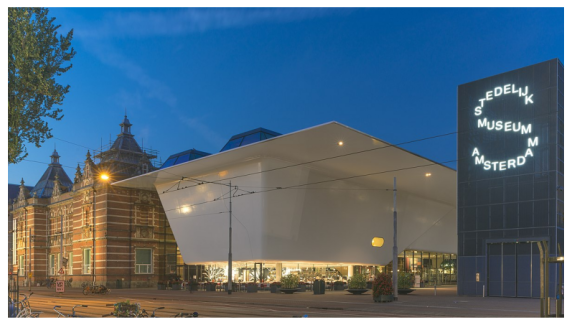

In [3]:
# Visualize the image
fig = plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
# Transform to 2D (Easier for convolution but not necessary)
# This calculates the mean along the flattened axis.
image_ = np.mean(image, axis=2)

# Normalize
image_ = image_ / np.max(image_)

# Image size
image_.shape

(670, 1200)

In [5]:
# Manually create 2 convolution kernels
v_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
h_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

# Convert to a 4D tensor
# Note: (1,1,3,3): # of images in a batch, # of channels, height, width.
# # of channels = 1 (since the color is greyed out)
v_kernel_T = torch.Tensor(v_kernel).view(1, 1, 3, 3)
h_kernel_T = torch.Tensor(h_kernel).view(1, 1, 3, 3)
image_T = torch.Tensor(image_).view(1, 1, image_.shape[0], image_.shape[1])

# Apply a 2D convolution over an input signal composed of several input planes.
C = F.conv2d(image_T, v_kernel_T)

# The shape of the data has dropped from (670, 1200) to (x, y, 668, 1198) because
# convolution reduces image size as the filter slides over the image, leaving some
# pixels uncovered and excluding them from the output.
C.shape

torch.Size([1, 1, 668, 1198])

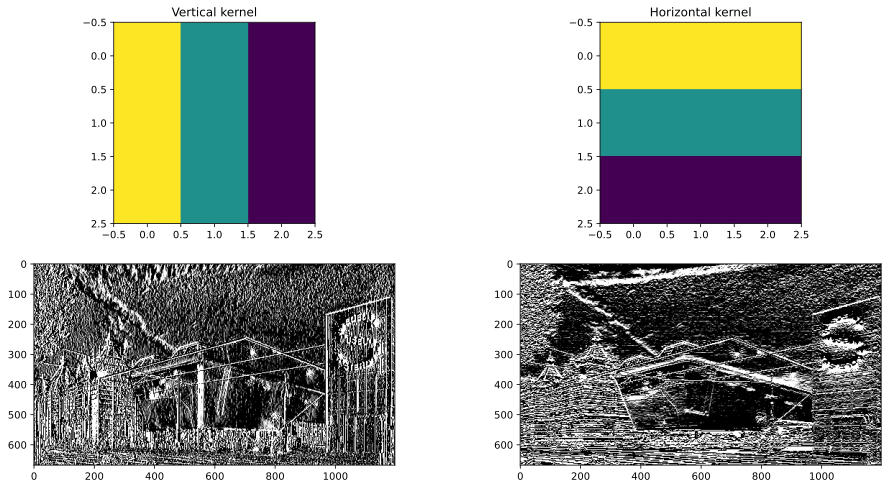

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

ax[0, 0].imshow(v_kernel)
ax[0, 0].set_title("Vertical kernel")

ax[0, 1].imshow(h_kernel)
ax[0, 1].set_title("Horizontal kernel")

# Apply convolution and show the result
conv_result = F.conv2d(image_T, v_kernel_T)
# Convert to 2D by removing the dims that are equal to 1
img = torch.squeeze(conv_result.detach())
ax[1, 0].imshow(img, cmap="gray", vmin=0, vmax=0.01)

conv_result = F.conv2d(image_T, h_kernel_T)
img = torch.squeeze(conv_result.detach())
ax[1, 1].imshow(img, cmap="gray", vmin=0, vmax=0.01)

plt.show()

## Padding

```text
- This is used to increase the size of the result of convolution so that the output matches with the size of the input data.
- It's a technique used to add zeros aound the edges of an input data before it's convolved with a filter. This is done to preserve the size of the input data after convolution.
- It's important for tasks such as image classification where it's important to presere the spatial information of the image.
```
<br>

## Stride

```text
- It's a parameter that controls how the convolution parameter moves over the input data. i.e. the number of pixels that the filter is moved over the input data in each step.
- A larger stride will result in a smaller output data while a smaller stride will result in a larger output data size.

Advantages of Using Stride
--------------------------
- It can reduce the computational complexity of the CNN.
- It can also reduce overfitting by reducing the amount of data the model is trained on.

Disadvantages
-------------
- It can reduce accuracy of the model by reducing the amount of information the model is able to learn from.
- It can also make the model more sensitive to noise in the input data.
```

### PyTorch's Conv2D Class

In [7]:
IN_CHANNELS = 3  # RGB: Number of channels in the input image
OUT_CHANNELS = 15  # Number of channels produced by the convolution
KERNEL_SIZE = 5  # Should be an odd number
STRIDE = 1  # Means no stride!
PADDING = 0  # Padding added to all four sides of the input. Default: 0

c = nn.Conv2d(
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    padding=PADDING,
)

c

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))

In [8]:
dir(c)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_conv_forward',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_s

In [9]:
# output_channels, input_channels, kernel_size, kernel_size
c.weight.shape

torch.Size([15, 3, 5, 5])

In [10]:
c.bias.shape

torch.Size([15])

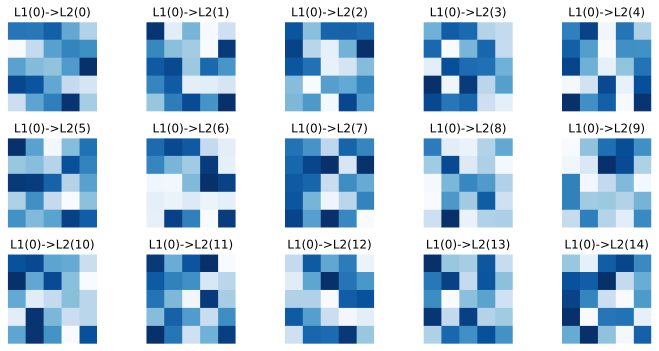

In [11]:
# Visualize the kernels
fig, axs = plt.subplots(3, 5, figsize=(10, 5))

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(c.weight[idx, 0, :, :]).detach(), cmap=plt.cm.Blues)
    ax.set_title(f"L1(0)->L2({idx})")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Create a random image
image_size = (1, 3, 64, 64)
image = torch.rand(image_size)

# PyTorch wants the channels 1st, but Matplotlib wants the channels last.
# Therefore, the image (tensor) must be permuted.
# 2, 3, and 1 are the indices of the original tensor
# index 0 and 1 are the numbe of images and image channel respectively.
image_2_view = image.permute(2, 3, 1, 0).numpy()

print(f"\nOriginal image: {image.shape}")
print(f"\nimage_2_view: {image_2_view.shape}")


Original image: torch.Size([1, 3, 64, 64])

image_2_view: (64, 64, 3, 1)


In [13]:
# Convolve the image with the filter
conv_result = c(image)

print(f"\nOriginal image: {image.shape}")
print(f"Kernel: {c.weight.shape}")

# The size of the convolved image is reduced and can be preserved using `padding`
print(f"Convolved image: {conv_result.shape}")


Original image: torch.Size([1, 3, 64, 64])
Kernel: torch.Size([15, 3, 5, 5])
Convolved image: torch.Size([1, 15, 60, 60])


##### Convoluted Image Shape Explanation

```text
Convolved image: [1, 15, 60, 60]
---------------
1 => The number of images.
15 => The number of feature maps which is as a result of the convolution.
60x60 => The size as a result of the convolution.
```

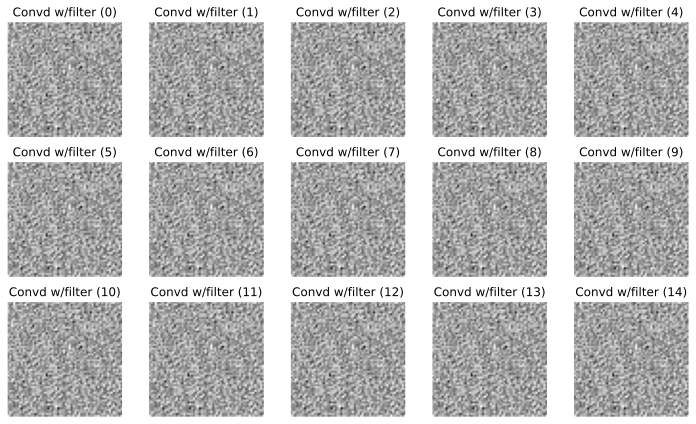

In [14]:
# Visualize the convolved image with 15 feature maps
fig, axs = plt.subplots(3, 5, figsize=(10, 6))


for idx, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(conv_result[0, 1, :, :]).detach(), cmap=plt.cm.Greys)
    ax.set_title(f"Convd w/filter ({idx})")
    ax.axis("off")

plt.tight_layout()
plt.show()

<hr><br>

## Transpose Convolution

```text
- It's also known as `deconvolution` which is a way of upsampling an image i.e. increasing the size of an image w/o introducng any new info by scalar multiplying the image with the filter.

- This works by reversing the process of convolution. The filter is moved in the opposite direction. i.e. from the output image to the input image and the output of the transpose convolution is the new image that's the same size as the input image.


Applications
------------

- Image upsampling
- Generative adversarial networks (GANs)
- Text-to-image generation
```

In [15]:
IN_CHANNELS = 3  # RGB: Number of channels in the input image
OUT_CHANNELS = 15  # Number of channels produced by the convolution
KERNEL_SIZE = 5  # Should be an odd number
STRIDE = 1  # Means no stride!
PADDING = 0  # Padding added to all four sides of the input. Default: 0

c_transp = nn.ConvTranspose2d(
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    kernel_size=KERNEL_SIZE,
    stride=STRIDE,
    padding=PADDING,
)
c_transp

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))

In [16]:
print(f"Normal Convolution: {c}\nTranspose Convolution: {c_transp}")


print(
    f"\nNormal Convolution: {c.weight.shape}\nTranspose Convolution: {c_transp.weight.shape}"
)

Normal Convolution: Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
Transpose Convolution: ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))

Normal Convolution: torch.Size([15, 3, 5, 5])
Transpose Convolution: torch.Size([3, 15, 5, 5])


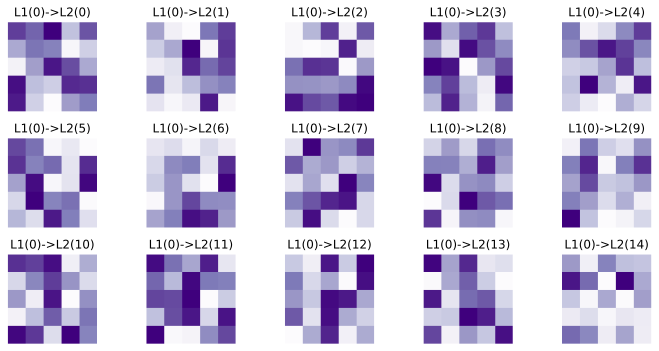

In [17]:
# Visualize the kernels
fig, axs = plt.subplots(3, 5, figsize=(10, 5))

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(
        torch.squeeze(c_transp.weight[0, idx, :, :]).detach(), cmap=plt.cm.Purples
    )
    ax.set_title(f"L1(0)->L2({idx})")
    ax.axis("off")

plt.tight_layout()
plt.show()


Original image: torch.Size([1, 3, 64, 64])

image_2_view: (64, 64, 3, 1)


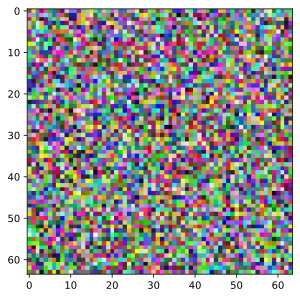

In [18]:
# Convolve with an image
# N: number of images
# size of the image (N, RGB, width, height)
image_size = (1, 3, 64, 64)  # Create a random image
image = torch.rand(image_size)

# PyTorch wants the channels 1st, but Matplotlib wants the channels last.
# Therefore, the image (tensor) must be permuted.
# 2, 3, and 1 are the indices of the original tensor
# index 0 and 1 are the numbe of images and image channel respectively.
image_2_view = image.permute(2, 3, 1, 0).numpy()

print(f"\nOriginal image: {image.shape}")
print(f"\nimage_2_view: {image_2_view.shape}")

plt.imshow(np.squeeze(image_2_view))
plt.show()

In [19]:
# Convolve the image with the filter
conv_result = c(image)

print(image.shape)
conv_result.shape

torch.Size([1, 3, 64, 64])


torch.Size([1, 15, 60, 60])

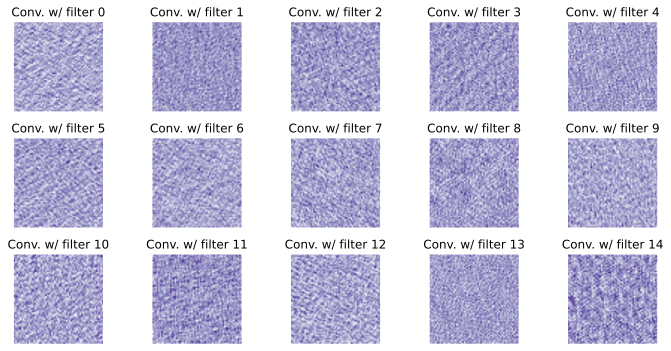

In [20]:
fig, axs = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    # extract this "layer" of the convolution result
    I = torch.squeeze(conv_result[0, i, :, :]).detach()

    # and visualize it
    ax.imshow(I, cmap="Purples")
    ax.set_title("Conv. w/ filter %s" % i)
    ax.axis("off")

plt.tight_layout()
plt.show()

<hr><br>

## Pooling

```text
- It's technique used to downsample or reduce the spatial dimensions of feature maps extracted from convolutional layers.

Max Pooling
-----------

- It takes the maximum value of each region of the feature map.
- It helps to preserve the most important features in the image, such as edges and corners.
- It's used for object recognition.

Mean Pooling
-----------

- It takes the average value of each region of the feature map.
- It helps to reduce noise and smooth out the feature map.
- It's used for object segmentation.

----------------------------------------------------------------------------------------------

2D Pooling
----------

- It's used for images which are 2D data.
- It takes the rectangular region of the feature map and outputs the maximum or average value from that region.
- It helps to reduce noise and smooth out the feature map.
- It helps to preserve the most important features in the image.
- It's used for image classification.

3D Pooling
----------

- It's used for volumetric data such as medical images or video frames
- It takes the cubic region of the feature map and outputs the maximum or average value from that region.
- It helps to reduce noise and smooth out the feature map.
- It helps to preserve the most important features in the image.
- It's used for 3D object rrecognition and medica image segmentation.
```

In [21]:
# Create a pool class
POOL_SIZE = 3  # pool size
STRIDE = 3

p_2d = nn.MaxPool2d(kernel_size=POOL_SIZE, stride=STRIDE)
p_3d = nn.MaxPool3d(kernel_size=POOL_SIZE, stride=STRIDE)

print(f"2D Pooling: {p_2d}\n3D Pooling: {p_3d}")

2D Pooling: MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
3D Pooling: MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [22]:
# Create image and apply pooling
image_1 = torch.rand(1, 1, 30, 30)  # greyscale image
image_2 = torch.rand(1, 3, 30, 30)  # coloured image (it has RGB)

pooled_2d_image = p_2d(image_1)
pooled_2d_1_image = p_2d(image_2)
pooled_3d_image = p_3d(image_2)


print(
    f"2D Pooling on 2D image: {pooled_2d_image.shape}\n2D Pooling on 3D image: {pooled_2d_1_image.shape}\n3D Pooling on 3D image: {pooled_3d_image.shape}"
)

2D Pooling on 2D image: torch.Size([1, 1, 10, 10])
2D Pooling on 3D image: torch.Size([1, 3, 10, 10])
3D Pooling on 3D image: torch.Size([1, 1, 10, 10])


#### Note

```text
3D pooling can only be applied to a 3D data.
```

In [23]:
try:
    p_3d(image_1)
except RuntimeError as err:
    print(err)

Given input size: (1x1x30x30). Calculated output size: (1x0x10x10). Output size is too small


In [24]:
IN_CHANNELS = 3  # RGB: Number of channels in the input image
OUT_CHANNELS = 10  # Number of channels produced by the convolution
KERNEL_SIZE = 5  # Should be an odd number
STRIDE = 3  # Means no stride!
PADDING = 2  # Padding added to all four sides of the input. Default: 0

POOL_SIZE = 3  # pool size
STRIDE = 3

# Create a simple CNN
net = nn.Sequential(
    # ========== Convolution pool block ==========
    nn.Conv2d(  # Conv layer
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        kernel_size=KERNEL_SIZE,
        stride=STRIDE,
        padding=PADDING,
    ),
    nn.ReLU(),  # Activation func
    nn.AvgPool3d(kernel_size=POOL_SIZE, stride=STRIDE),  # output of the conv layer
    #
    #
    # ========== FFN block ==========
    nn.Flatten(),
    nn.Linear(588, 1),
    nn.Sigmoid(),  # Output activation func
)

net

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool3d(kernel_size=3, stride=3, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=588, out_features=1, bias=True)
  (5): Sigmoid()
)

In [25]:
image = torch.rand(1, 3, 128, 128)
net(image)

tensor([[0.5030]], grad_fn=<SigmoidBackward0>)